# Variational Autoencoders

VAEs consider two-step generative process by a prior over latent space $p(z)$ and a conditional generative distribution $p_{\theta}(x|z)$, which is parametrized by a deep neural network (DNN). Our goal is to maximize marginal log-likehood  which is intractable in general case. Therefore, variational inference (VI) framework is considered.

\begin{equation*}
    \begin{aligned}
    & \log p(x) \geq \mathcal{L}(x;\theta;q) = \mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \text{KL}[q(z)\|p(z)],
    \end{aligned}
\end{equation*}

where $q(z|x)$ is a variational posterior distribution. Given data distribution $p_e(x) = \frac1N\sum_{i=1}^N \delta_{x_i}$ we aim at maximizing the average marginal log-likelihood. Following the variational auto-encoder architecture amortized inference is proposed by choice of the variational distribution $q_{\phi}(z|x)$ which is also parametrized by DNN.

\begin{equation*}
    \begin{aligned}
    & \arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathcal{L}(x,\phi,\theta)=\arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \mathbb{E}_x \text{KL}[q_{\phi}(z|x)\|p(z)].
    \end{aligned}
\end{equation*}

To evaluate the performance of the VAE approach, we will estimate a negative log likelihood (NLL) on the test set. NLL is calculated by importance sampling method:
\begin{equation*}
   - \log p(x) \approx - \log \frac{1}{K} 
   \sum_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x)     
\end{equation*}

### References
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf
2. Beta-VAE https://pdfs.semanticscholar.org/a902/26c41b79f8b06007609f39f82757073641e2.pdf
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf 
4. VAE with a VampPrior https://arxiv.org/pdf/1705.07120.pdf 

## VAE
Implement all the method in the class `SimpleVAE` below, using the formular above and detail in the documentation

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam
from google.colab import drive
from google.colab import files
from torch.utils.data import TensorDataset, DataLoader
drive.mount('/content/gdrive')
%matplotlib inline


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda')
torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.cuda.set_device(0)

True


In [0]:
class SimpleVAE(nn.Module):
    def __init__(self, hid_dim, input_size, achitecture=True):
        super(SimpleVAE, self).__init__()
        self.hid_dim = hid_dim
        self.input_size = input_size
        self.encoder = nn.Sequential(
                        nn.Linear(input_size, hid_dim),
                        nn.Tanh(),
                        nn.Linear(hid_dim, hid_dim),
                        nn.Tanh(),
                        nn.Linear(hid_dim, hid_dim),
                        )
       
        self.decoder = nn.Sequential(
                        nn.Linear(hid_dim//2, hid_dim),
                        nn.Tanh(),
                        nn.Linear(hid_dim, hid_dim),
                        nn.Tanh(),
                        nn.Linear(hid_dim, 2*input_size),
                       )
        self.init_params()

        
    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_z(self, x):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """
        
        out = self.encoder.forward(x)
        mu = out[:,:self.hid_dim//2]
        log_sigma_2 = torch.tensor(4.)*torch.sigmoid(out[:, self.hid_dim//2:]) - torch.tensor(2.)
        return mu, log_sigma_2      
        

    def p_x(self, z):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, hid_dim)
        :return: parameters of p(x|z)    (MB, inp_dim)
        """
        
        out = self.decoder.forward(z)
        mu = torch.sigmoid(out[:, :self.input_size])
        log_sigma_2 = torch.tensor(4.)*out[:, self.input_size:]- torch.tensor(2.)
        return mu, log_sigma_2

    def forward(self, x):
        """
        Encoder the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        
        m_q, log_sigma_q = self.q_z(x)
        z_hat = self.reparameterize(m_q, log_sigma_q)
        m_p, log_sigma_p = self.p_x(z_hat)
        return m_p, log_sigma_p, z_hat, m_q, log_sigma_q

    def log_p_z(self, z):
        """
        Log density of the Prior
        :param z: latent vector     (MB, hid_dim)
        :return: \sum_i log p(z_i)  (1, )
        """

        return ((-self.hid_dim//2)*torch.log(torch.tensor(2*3.14)) - (z**2).sum(dim=1)/2).sum()

    def reconstruct_x(self, x):
        x_mean, _, _, _, _ = self.forward(x)
        return x_mean

    
    def kl(self, z_mean, z_logvar):
        """
        KL-divergence between p(z) and q(z|x)
        :param z:                               (MB, hid_dim)
        :param z_mean: mean of q(z|x)           (MB, hid_dim)
        :param z_logvar: log variance of q(z|x) (MB, hid_dim)
        :return: KL                             (MB, )
        """
        
        D = -1/2 * (-(z_mean**2).sum(dim=1) - torch.exp(z_logvar).sum(dim=1) + (1+z_logvar).sum(dim=1))
        
        return D

    def calculate_loss(self, x, beta=1., average=True):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :param average: Compute average over mini batch or not, bool
        :return: -RE + beta * KL  (MB, ) or (1, )
        """
       
        MB = x.size()[0]
        log_p_x = torch.zeros(MB, device=device)
        z_mean_, z_logvar_ = self.q_z(x)
        kl_d = self.kl(z_mean_, z_logvar_)
        for _ in range(100):
            z_sample = self.reparameterize(z_mean_, z_logvar_)
            x_mean, x_logvar = self.p_x(z_sample)
            log_p_x = log_p_x + (-self.input_size/2)*torch.log(torch.tensor(2*3.14)) - x_logvar.sum(dim=1)/2  - (((x-x_mean)**2)/torch.exp(x_logvar)).sum(dim=1)/2
        if average:    
          return -log_p_x.mean()/100+beta*kl_d.mean(), kl_d.mean()
        else:
          return -log_p_x/100+beta*kl_d, kl_d

    def calculate_nll(self, x, samples=5000):
        """
        Estimate NLL by importance sampling
        :param X: dataset, (N, inp_dim)
        :param samples: Samples per observation
        :return: IS estimate
        """
        
        z_mean, z_logvar = self.q_z(x)
        sum_prob = torch.tensor(0.)
        
        for i in range(samples):
            z = self.reparameterize(z_mean, z_logvar)
            x_mean, x_logvar = self.p_x(z)
            p_z_i = self.log_p_z(z).exp_()
            q_z_i = (((-self.hid_dim//2)*torch.log(torch.tensor(2*3.14)) - z_logvar.sum(dim=1)/2  - (((z-z_mean)**2)/torch.exp(z_logvar)).sum(dim=1)/2).sum()).exp_()
            p_x_z = (((-self.input_size//2)*torch.log(torch.tensor(2*3.14)) - x_logvar.sum(dim=1)/2  - (((x-x_mean)**2)/torch.exp(x_logvar)).sum(dim=1)/2).sum()).exp_()
            
            
            sum_prob = sum_prob + p_x_z*p_z_i/q_z_i
        
        return -torch.log(sum_prob/samples)

    def generate_x(self, N=25):
        """
        Sample, using you VAE: sample z from prior and decode it 
        :param N: number of samples
        :return: X (N, inp_size)
        """
        X = torch.zeros((N, self.input_size))
        for i in range(N):
            mu = torch.zeros(1, self.hid_dim//2)
            logvar = torch.zeros(1, self.hid_dim//2)
            z_hat = self.reparameterize(mu, logvar)
            X[i], _ = self.p_x(z_hat)
            
        return X

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(logvar*(0.5))
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        return eps*std+mu

## Generalization

We will evaluate generalization of our generative model using the approahc discussed in https://arxiv.org/abs/1811.03259.

Download the dataset with dots [here](https://drive.google.com/open?id=1CsDMOIGEsD1l3BLhuQDfEfEmLEb83wMz)

1. [50 pts] Train your VAE on the **subset** of dots contating only 3 points (use batch 0-5 for training and leave 6 and 7 as a test set). Plot ELBO vs Iteration, KL vs Iteration 
2. [10 pts] Calculate NLL on a test set, contating only 3 dots 
3. [10 pts] Calculate NLL on a test set, containing only 5 dots 
4. [30 pts] Sample 25 images from the VAE and draw then on the 5 $\times$ 5 grid. Comment on the generalization ability of the model 

In [6]:
# Training VAE
drive.mount('/content/gdrive')
input_size = 64*64*3
hid_dim = 64
model = SimpleVAE(hid_dim, input_size)
model.to(device)
n_epochs = 4
ELBO_graph = [] 
KL_graph = []
optimizer = Adam([{'params': model.encoder.parameters()}, {'params': model.decoder.parameters()}], lr=0.0001)
batch_size = 256

for i in range(n_epochs):
    print('++++ Epoch', i+1, '++++')
    for j in range(6):
        print('==== file ===', j)
        file_name = '/content/gdrive/My Drive/HW3_BMML/dots/3_dots/batch'+str(j)+'.npz'
        y = np.load(file_name)
        images = y['images']
        images = torch.tensor(images, device=device)
        optimizer.zero_grad()
        train = DataLoader(images.view(-1, 64*64*3), batch_size = 256)
        
        for inputs in train:
          inputs = inputs.to(device)
                    
          optimizer.zero_grad()
          elbo, KL = model.calculate_loss(inputs, beta=250.)          
          print('ELBO = ', elbo.cpu().data.numpy(), '  KL =', KL.cpu().data.numpy())
          elbo.backward()
          optimizer.step()
          
          ELBO_graph.append(elbo.cpu().data.numpy())
          KL_graph.append(KL.cpu().data.numpy())
          torch.cuda.empty_cache()           
        
        
        
# your code here

Mounted at /content/gdrive
++++ Epoch 1 ++++
==== file === 0


Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f8380cb0080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


ELBO =  11792.018   KL = 5.7195897
ELBO =  11794.6455   KL = 5.7134323
ELBO =  11352.375   KL = 4.06543
ELBO =  11208.878   KL = 3.5751145
ELBO =  11038.822   KL = 2.9653902
ELBO =  10887.787   KL = 2.3864875
ELBO =  10857.574   KL = 2.3365324
ELBO =  10857.883   KL = 2.4296741
ELBO =  10821.239   KL = 2.3440886
ELBO =  10760.337   KL = 2.156023
ELBO =  10691.158   KL = 1.9476261
ELBO =  10640.127   KL = 1.8159212
ELBO =  10607.097   KL = 1.7386475
ELBO =  10567.927   KL = 1.6488328
ELBO =  10544.656   KL = 1.6737018
ELBO =  10530.115   KL = 1.689059
ELBO =  10487.672   KL = 1.6271174
ELBO =  10450.63   KL = 1.5662282
ELBO =  10421.18   KL = 1.4844903
ELBO =  10404.065   KL = 1.427447
ELBO =  10368.048   KL = 1.3711417
ELBO =  10331.072   KL = 1.3381314
ELBO =  10305.7   KL = 1.3295351
ELBO =  10274.413   KL = 1.3234589
ELBO =  10249.8955   KL = 1.2793307
ELBO =  10214.807   KL = 1.2476944
ELBO =  10191.056   KL = 1.2374189
ELBO =  10161.64   KL = 1.225184
ELBO =  10121.785   KL = 1.19

Text(0.5, 1.0, 'ELBO vs Iteration')

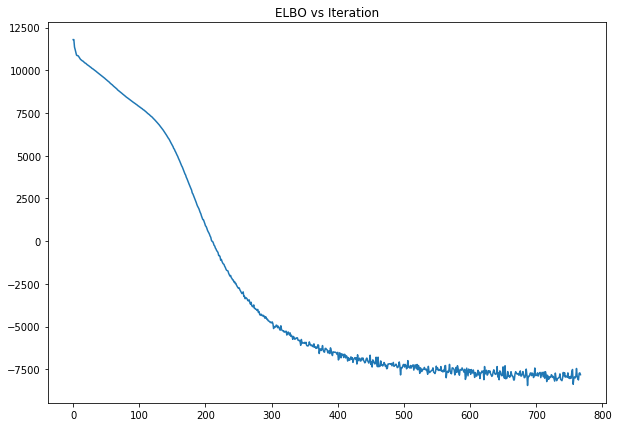

In [7]:
plt.figure(figsize = (10, 7))
plt.plot(ELBO_graph)
plt.title('ELBO vs Iteration')

Text(0.5, 1.0, 'KL vs Iteration')

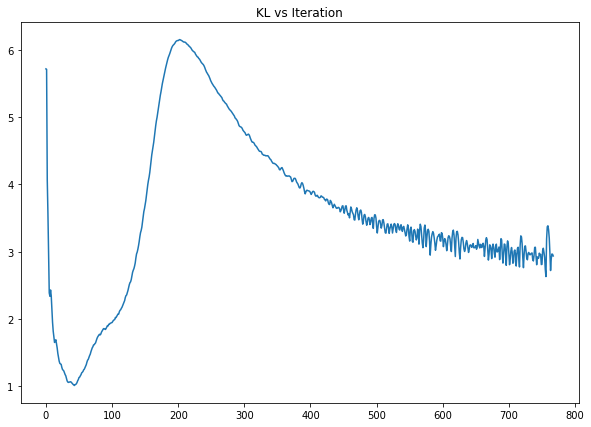

In [8]:
plt.figure(figsize = (10, 7))
plt.plot(KL_graph)
plt.title('KL vs Iteration')

In [12]:
# NLL for 3 dots per image

# your code here
drive.mount('/content/gdrive')
NLL_3 = []
torch.cuda.empty_cache()
model.eval()
for j in [6, 7]:
    print('==== file ===', j)
    file_name = '/content/gdrive/My Drive/HW3_BMML/dots/3_dots/batch'+str(j)+'.npz'
    y = np.load(file_name)
    images = y['images']
    images = torch.tensor(images, device=device)
    train = DataLoader(images.view(-1, 64*64*3), batch_size = 32)
    k=0    
    for inputs in train:
      inputs = inputs.to(device)
      nll = model.calculate_nll(inputs, samples=10)          
      NLL_3.append(nll.cpu().data.numpy())
      torch.cuda.empty_cache()

print('NLL')
print(NLL_3)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
==== file === 6
==== file === 7
NLL
[array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float

In [14]:
# NLL for 5 dots per image
NLL_5 = []
model.eval()
for j in [6, 7]:
    print('==== file ===', j)
    file_name = '/content/gdrive/My Drive/HW3_BMML/dots/5_dots/batch'+str(j)+'.npz'
    y = np.load(file_name)
    images = y['images']
    images = torch.tensor(images, device=device)
    train = DataLoader(images.view(-1, 64*64*3), batch_size = 32)
        
    for inputs in train:
      inputs = inputs.to(device)
      nll = model.calculate_nll(inputs, samples=100)          
      #print('nll = ', nll.cpu().data.numpy())
      NLL_5.append(nll.cpu().data.numpy())
      torch.cuda.empty_cache()
      
print('NLL')
print(NLL_5)

# your code here

==== file === 6
==== file === 7
NLL
[array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=f

Due to very small values of probability densities included in formula for NLL, in my case there is no possibility to compute NLL. (In article 4, I found the value of NLL that was equal to 84 that corresponds to $10^{-37}$ value of probability=))

In [19]:
torch.finfo(torch.float64).eps

2.220446049250313e-16

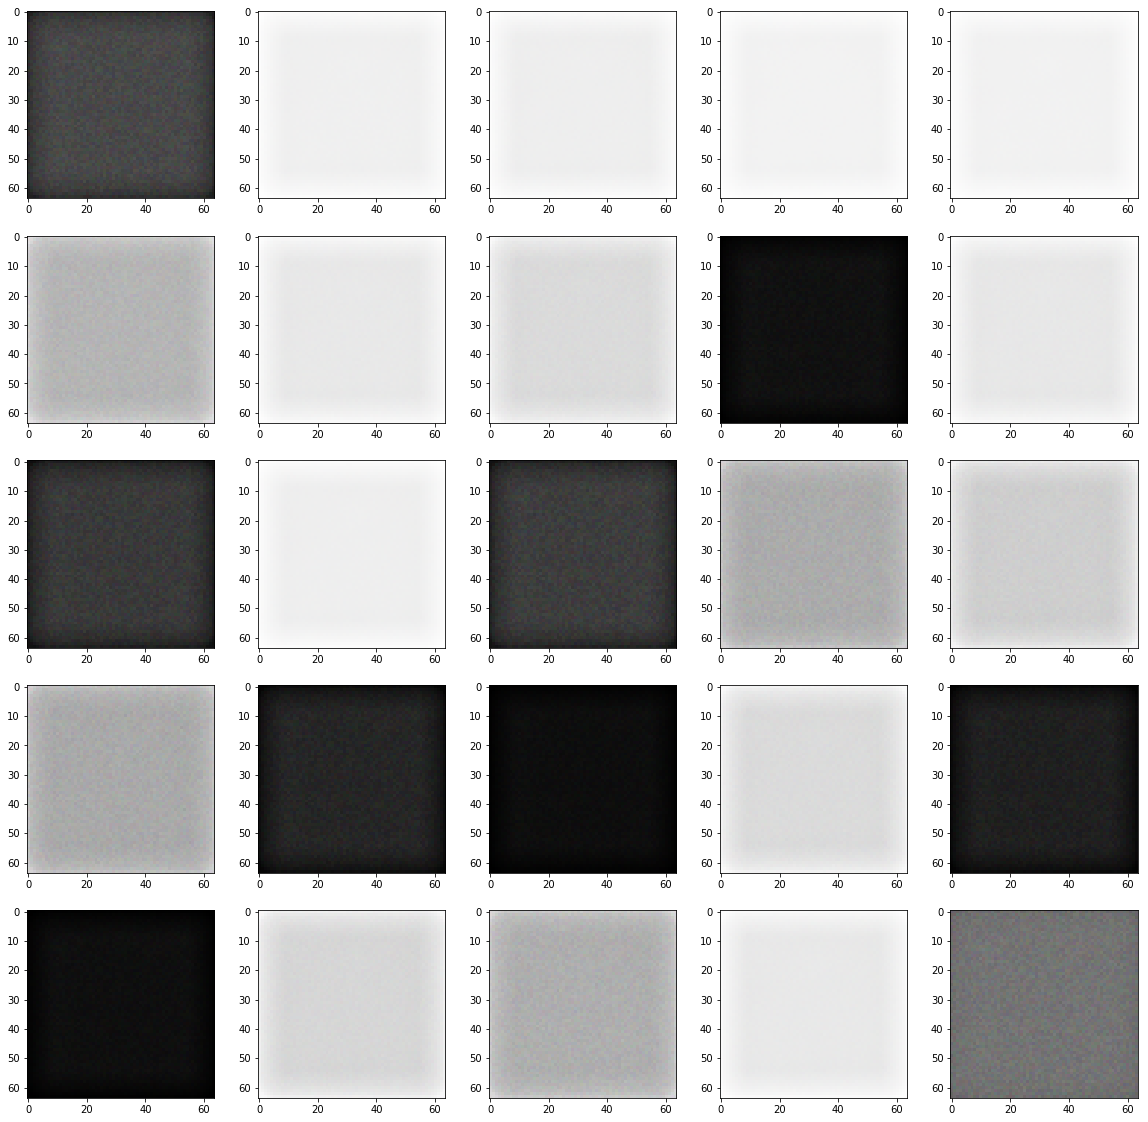

In [20]:
# Sampling
X = model.generate_x()
images = X.view(25, 64, 64, 3).cpu().data.numpy()
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(5):
  for j in range(5):
    ax[i, j].imshow(images[i*5+j, :, :, :]);
# your code here

Unfortunately, generalization ability is weak due to the noise generation istead of dots.